In [1]:
#Base
import os, warnings
import numpy as np
import pandas as pd
from scipy import interpolate
import scipy.stats as st

#Plot
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import seaborn as sns

color_names=['amber','red','windows blue','faded green',
             'dusty purple',
             'orange',
             'steel blue',
             'pink',
             'greyish',
             'mint',
             'clay',
             'light cyan',
             'forest green',
             'pastel purple',
             'salmon',
             'dark brown',
             'lavender',
             'pale green',
             'dark red',
             'gold',
             'dark teal',
             'rust',
             'fuchsia',
             'pale orange',
             'cobalt blue',
             'mahogany',
             'cloudy blue',
             'dark pastel green',
             'dust',
             'electric lime',
             'fresh green',
             'light eggplant',
             'nasty green']
 
color_palette = sns.xkcd_palette(color_names)
cc = sns.xkcd_palette(color_names)

%matplotlib inline
%load_ext autoreload
%autoreload 2


In [50]:
from glob import glob
file_list = sorted(glob('/home/david.wyrick/projects/V1DD/data/dff_409828_13*'))
file_list


['/home/david.wyrick/projects/V1DD/data/dff_409828_13_1_all-rois.npz',
 '/home/david.wyrick/projects/V1DD/data/dff_409828_13_2_all-rois.npz',
 '/home/david.wyrick/projects/V1DD/data/dff_409828_13_3_all-rois.npz',
 '/home/david.wyrick/projects/V1DD/data/dff_409828_13_4_all-rois.npz',
 '/home/david.wyrick/projects/V1DD/data/dff_409828_13_5_all-rois.npz',
 '/home/david.wyrick/projects/V1DD/data/dff_409828_13_6_all-rois.npz']

In [51]:
data_list = [] 
stim_list = []
ts_list = []
for fpath in file_list:
    stim = fpath[38:-4]
    data = np.load(fpath)
    dF_traces = data['dF_traces']
    ts_list.append(data['ts'])
    stim_list.append(stim)
    print(stim, ': ', dF_traces.shape)
    data_list.append(dF_traces)

dff_409828_13_1_all-rois :  (1234, 21616)
dff_409828_13_2_all-rois :  (1222, 21616)
dff_409828_13_3_all-rois :  (1482, 21616)
dff_409828_13_4_all-rois :  (1279, 21616)
dff_409828_13_5_all-rois :  (1158, 21616)
dff_409828_13_6_all-rois :  (1148, 21616)


In [4]:
#Cascade
# cascade2p packages, imported from the downloaded Github repository
%cd '/home/david.wyrick/Git/Cascade'
print('New working directory:', os.getcwd() )
PlotDir = '/home/david.wyrick/projects/V1DD/plots'

# cascade2p packages, imported from the downloaded Github repository
from cascade2p import checks
checks.check_packages()
from cascade2p import cascade # local folder
from cascade2p.utils import plot_dFF_traces, plot_noise_level_distribution, plot_noise_matched_ground_truth

/home/david.wyrick/Git/Cascade
New working directory: /home/david.wyrick/Git/Cascade
	YAML reader installed (version 0.17.21).


Using TensorFlow backend.


	Keras installed (version 2.3.1).
	Tensorflow installed (version 2.3.0).


/home/david.wyrick/anaconda3/envs/Cascade/lib/python3.7/site-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")


In [43]:
nNeurons_plane = [1234, 1222, 1482, 1279, 1158, 1148]
plane_boundaries = np.cumsum(nNeurons_plane)
plane_boundaries

array([1234, 2456, 3938, 5217, 6375, 7523])

In [25]:
mask = np.load('/home/david.wyrick/projects/V1DD/data/plane3_mask.npy')
np.sum(mask)

483

(1482, 987)


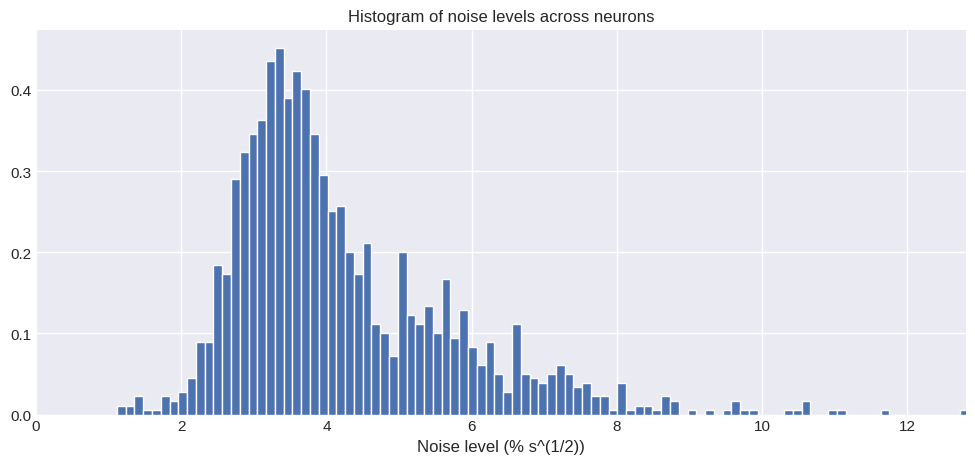

In [44]:
traces = data_list[8][2456:3938]
print(traces.shape)
frame_rate = 6

#@markdown For each neuron in the loaded dataset, the noise level will be computed and the distribution across neurons will be shown.
warnings.filterwarnings('ignore')

plt.rcParams['figure.figsize'] = [12, 5]

noise_levels = plot_noise_level_distribution(traces,frame_rate)

In [45]:
#@markdown Select (from the list above) and download the model that fits to your dataset (frame rate, training data; see FAQ for more details) and assign to variable **`model_name`**.

model_name = "Global_EXC_6Hz_smoothing200ms" #@param {type:"string"}

cascade.download_model( model_name,verbose = 1)

Pretrained model was saved in folder "/home/david.wyrick/Git/Cascade/Pretrained_models/Global_EXC_6Hz_smoothing200ms"


## Predict spike rates from ΔF/F traces

In [46]:
#@markdown If this takes too long, make sure that the GPU runtime is activated (*Menu > Runtime > Change Runtime Type*).

total_array_size = traces.itemsize*traces.size*64/1e9

# If the expected array size is too large for the Colab Notebook, split up for processing
if total_array_size < 10:

  spike_prob = cascade.predict( model_name, traces, verbosity=1 )

# Will only be use for large input arrays (long recordings or many neurons)
else:
  
  print("Split analysis into chunks in order to fit into Colab memory.")

  # pre-allocate array for results
  spike_prob = np.zeros((traces.shape))
  # nb of neurons and nb of chuncks
  nb_neurons = traces.shape[0]
  nb_chunks = np.int(np.ceil(total_array_size/10))

  chunks = np.array_split(range(nb_neurons), nb_chunks)
  # infer spike rates independently for each chunk
  for part_array in range(nb_chunks):
    spike_prob[chunks[part_array],:] = cascade.predict( model_name, traces[chunks[part_array],:] )


 
The selected model was trained on 18 datasets, with 5 ensembles for each noise level, at a sampling rate of 6Hz, with a resampled ground truth that was smoothed with a Gaussian kernel of a standard deviation of 200 milliseconds. 
 

Loaded model was trained at frame rate 6 Hz
Given argument traces contains 1482 neurons and 987 frames.
Noise levels (mean, std; in standard units): 4.22, 1.55

Predictions for noise level 2:
	... ensemble 0
10/10 [==============================] - 0s 6ms/step
	... ensemble 1
10/10 [==============================] - 0s 6ms/step
	... ensemble 2
10/10 [==============================] - 0s 6ms/step
	... ensemble 3
10/10 [==============================] - 0s 7ms/step
	... ensemble 4
10/10 [==============================] - 0s 6ms/step

Predictions for noise level 3:
	... ensemble 0
60/60 [==============================] - 0s 8ms/step
	... ensemble 1
60/60 [==============================] - 0s 8ms/step
	... ensemble 2
60/60 [==============================] - 

In [57]:
spike_prob_all_sub  = spike_prob_all[:,indy]

In [56]:
spike_prob_all.shape
ts = ts_list[2]

tStart = 1179.571167; tEnd = 1331.681152	
indy = np.where((ts >= tStart) & (ts <= tEnd))[0]
len(indy)

921

In [65]:
spike_prob_sub = spike_prob[:,33:-33]
spike_prob_sub.shape

(1482, 921)

<AxesSubplot:ylabel='Count'>

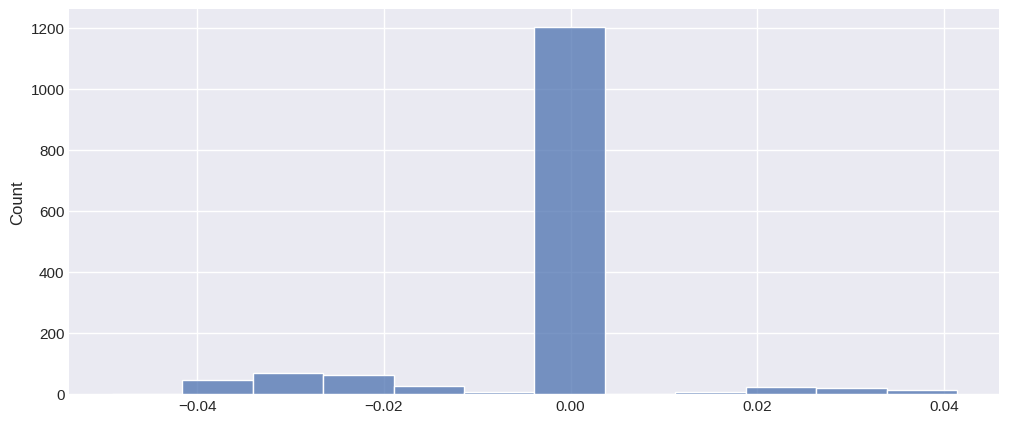

In [72]:
diff = np.mean(spike_prob_sub-spike_prob_all_sub,axis=1)
sns.histplot(diff)

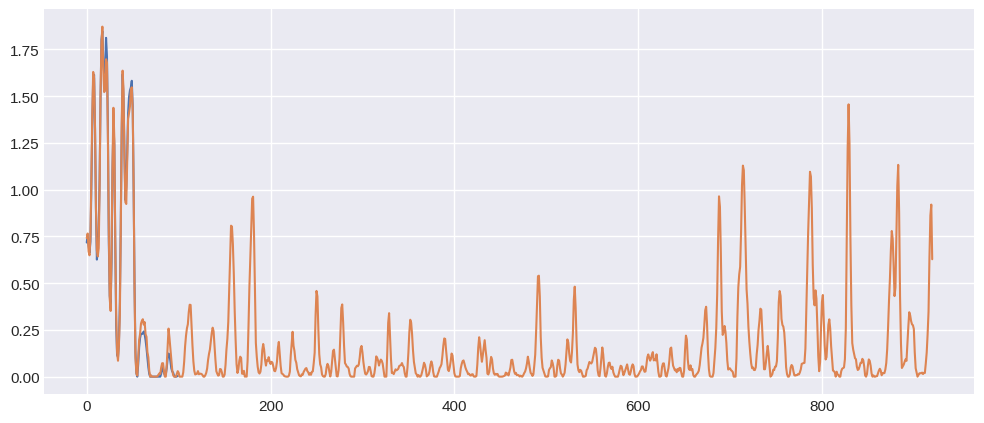

In [69]:
iN = 1

plt.plot(spike_prob_sub[iN,:100])
plt.plot(spike_prob_all_sub[iN,:1000])

## Plot randomly selected example predictions

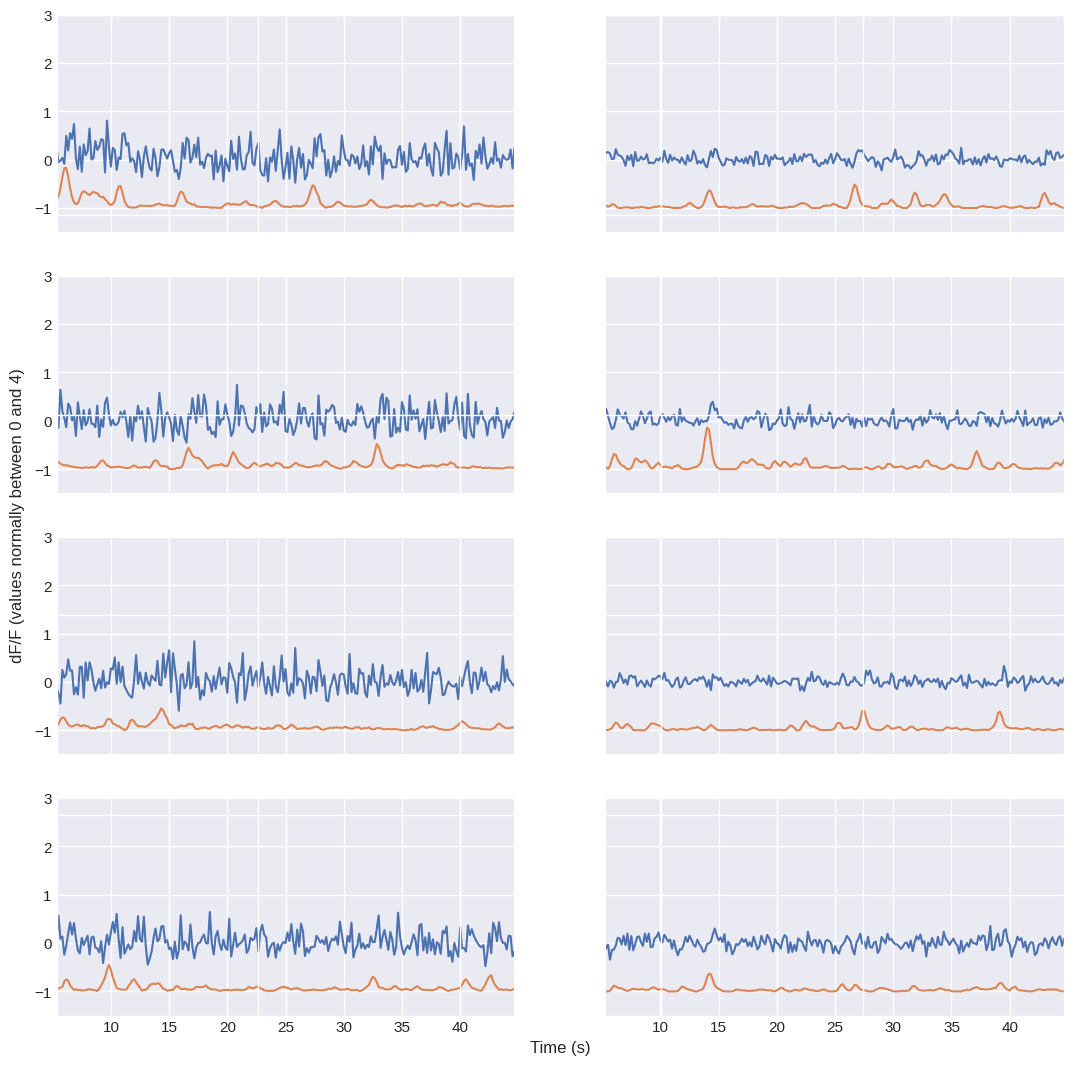

In [14]:
#@markdown By default plots a set of 16 randomly chosen neuronal traces (first seconds). The dF/F traces are shown in blue, the inferred spike probability is plotted in orange (shifted downwards by 1 for better visibility).

nb_neurons = 8

neuron_indices = np.random.randint(traces.shape[0], size=nb_neurons)
time_axis = plot_dFF_traces(traces,neuron_indices,frame_rate,spike_prob,y_range=(-1.5, 3))

## Plot noise-matched examples from the ground truth

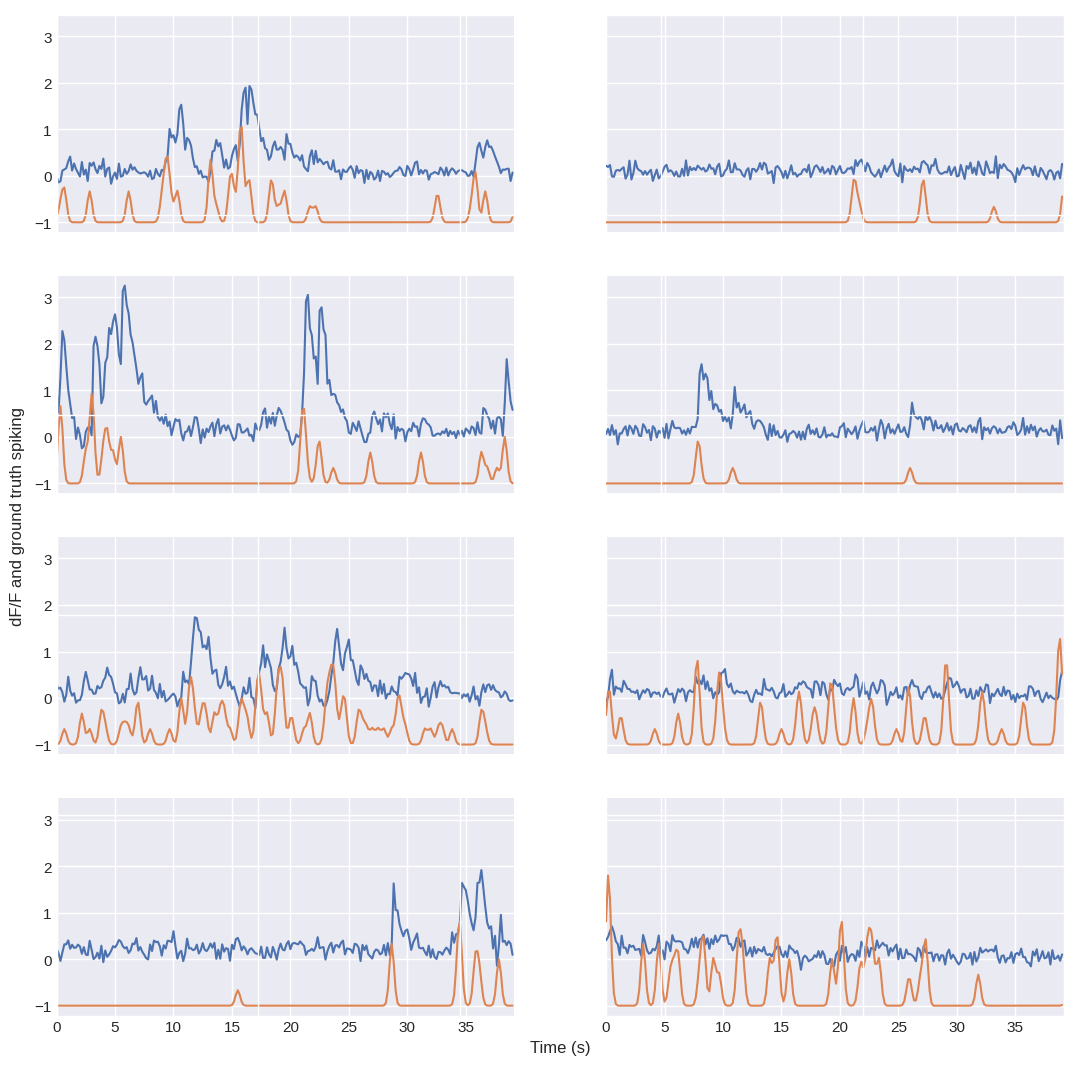

In [15]:
#@markdown Plots randomly drawn excerpts from the ground truth, re-sampled at the same frame rate and noise level as a typical recording of the test dataset. The resampled dF/F signal is shown in blue. The true spike rate convolved with a smoothing kernel is shown in orange (shifted downward by 1 for better visibility).

#@markdown This allows to directly compare **data quality** and **possible artifacts** of training dataset (ground truth) and test dataset (your calcium imaging data). 

#@markdown Repeatedly execute this cell to plot new examples. 

median_noise = np.round(np.maximum(2,np.median(noise_levels)))
nb_traces = 8
duration = max(time_axis) - 64/frame_rate # seconds
plot_noise_matched_ground_truth( model_name, median_noise, frame_rate, nb_traces, duration )

##  Run all stimuli

In [18]:

for stim, ts, traces, fpath in zip(stim_list,ts_list, data_list,file_list):
    print(stim)
    total_array_size = traces.itemsize*traces.size*64/1e9
    # If the expected array size is too large for the Colab Notebook, split up for processing
    if total_array_size < 10:

        spike_prob = cascade.predict( model_name, traces, verbosity=1 )

    # Will only be use for large input arrays (long recordings or many neurons)
    else:
        
        print("Split analysis into chunks in order to fit into Colab memory.")

        # pre-allocate array for results
        spike_prob = np.zeros((traces.shape))
        # nb of neurons and nb of chuncks
        nb_neurons = traces.shape[0]
        nb_chunks = np.int(np.ceil(total_array_size/10))

        chunks = np.array_split(range(nb_neurons), nb_chunks)
        # infer spike rates independently for each chunk
        for part_array in range(nb_chunks):
            spike_prob[chunks[part_array],:] = cascade.predict( model_name, traces[chunks[part_array],:] )

    #Save
    folder = os.path.dirname(fpath)
    file_name = 'predictions_' + os.path.splitext( os.path.basename(fpath))[0] + '.npz'
    save_path = os.path.join(folder, file_name)

    # save as numpy file
    spike_prob=spike_prob[:,32:-32]
    ts=ts[32:-32]
    np.savez(save_path, data=spike_prob,timestamps=ts)

dff_409828_13_1_all-rois
Split analysis into chunks in order to fit into Colab memory.

 
The selected model was trained on 18 datasets, with 5 ensembles for each noise level, at a sampling rate of 6Hz, with a resampled ground truth that was smoothed with a Gaussian kernel of a standard deviation of 200 milliseconds. 
 

Loaded model was trained at frame rate 6 Hz
Given argument traces contains 617 neurons and 21616 frames.
Noise levels (mean, std; in standard units): 2.07, 0.46

Predictions for noise level 2:
	... ensemble 0
1462/1462 [==============================] - 12s 8ms/step
	... ensemble 1
1462/1462 [==============================] - 11s 8ms/step
	... ensemble 2
1462/1462 [==============================] - 11s 8ms/step
	... ensemble 3
1462/1462 [==============================] - 11s 8ms/step
	... ensemble 4
1462/1462 [==============================] - 11s 8ms/step

Predictions for noise level 3:
	... ensemble 0
122/122 [==============================] - 1s 8ms/step
	... ensemb